In [1]:
%matplotlib inline
# import packages
from binance.client import Client
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import sklearn as skl
import pytz
import statsmodels.api as sm
import zipline
import pathlib

# get api keys for binance 
import os
API_PUBLIC = os.environ.get("PUBLIC_KEY")
API_SECRET = os.environ.get("SECRET_KEY")
CSV_PATH_PREFIX = os.environ.get("PATH_TO_PROJECT")

## Preliminaries: import data and visualise

In [2]:
# import data
df_hourly = {}
for key in os.listdir('hourly'):
    print(key[:-4]) # the weird slicing is to drop the .csv extension
    df_hourly[key[:-4]] = pd.read_csv('hourly/' + key)
    df_hourly[key[:-4]]['date'] = pd.to_datetime(df_hourly[key[:-4]]['date'])# ,unit='ms')
    df_hourly[key[:-4]].set_index('date', inplace=True)

ETHUSDT
BCHUSDT
BNBUSDT
BTCUSDT
XRPUSDT


In [3]:
# import data, far more minute data but quality is questionable
df_minutely = {}
for key in os.listdir('minute'):
    print(key[:-4]) # the weird slicing is to drop the .csv extension
    df_minutely[key[:-4]] = pd.read_csv('minute/' + key)
    df_minutely[key[:-4]]['date'] = pd.to_datetime(df_minutely[key[:-4]]['date'])# ,unit='ms')
    df_minutely[key[:-4]].set_index('date', inplace=True)

ETHUSDT
BCHUSDT
BNBUSDT
BTCUSDT
XRPUSDT


In [4]:
for key in df_minutely:
    df_minutely[key].fillna(method="ffill", inplace=True)

In [9]:
df

{'ETHUSDT':                        open    high     low   close       volume
 date                                                            
 2019-11-28 10:00:00  152.30  152.31  149.82  151.13  29357.23936
 2019-11-28 11:00:00  151.11  151.81  150.77  151.57   9538.34518
 2019-11-28 12:00:00  151.59  151.60  150.19  150.79   8435.91551
 2019-11-28 13:00:00  150.77  151.41  150.45  151.02  11315.29199
 2019-11-28 14:00:00  151.03  151.25  150.41  150.89   6933.90227
 2019-11-28 15:00:00  150.89  154.63  150.75  153.99  32527.39597
 2019-11-28 16:00:00  153.97  154.02  152.79  153.84  16824.95914
 2019-11-28 17:00:00  153.83  153.97  153.15  153.52   5385.28789
 2019-11-28 18:00:00  153.50  154.17  153.27  153.34   5755.25411
 2019-11-28 19:00:00  153.34  154.22  153.27  153.69   5918.28565
 2019-11-28 20:00:00  153.69  154.23  152.06  152.06  11034.16930
 2019-11-28 21:00:00  152.06  152.52  151.33  151.90  10761.80048
 2019-11-28 22:00:00  151.89  152.59  150.03  150.22  10584.23538

In [5]:
df = df_hourly
# df = df_minutely

/home/joseph/miniconda3/envs/mscfe3/lib/python3.6/site-packages/pandas/plotting/_compat.py:57: MatplotlibDeprecationWarning: 
The compare_versions function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  return matplotlib.compare_versions('2.0.0', matplotlib.__version__)


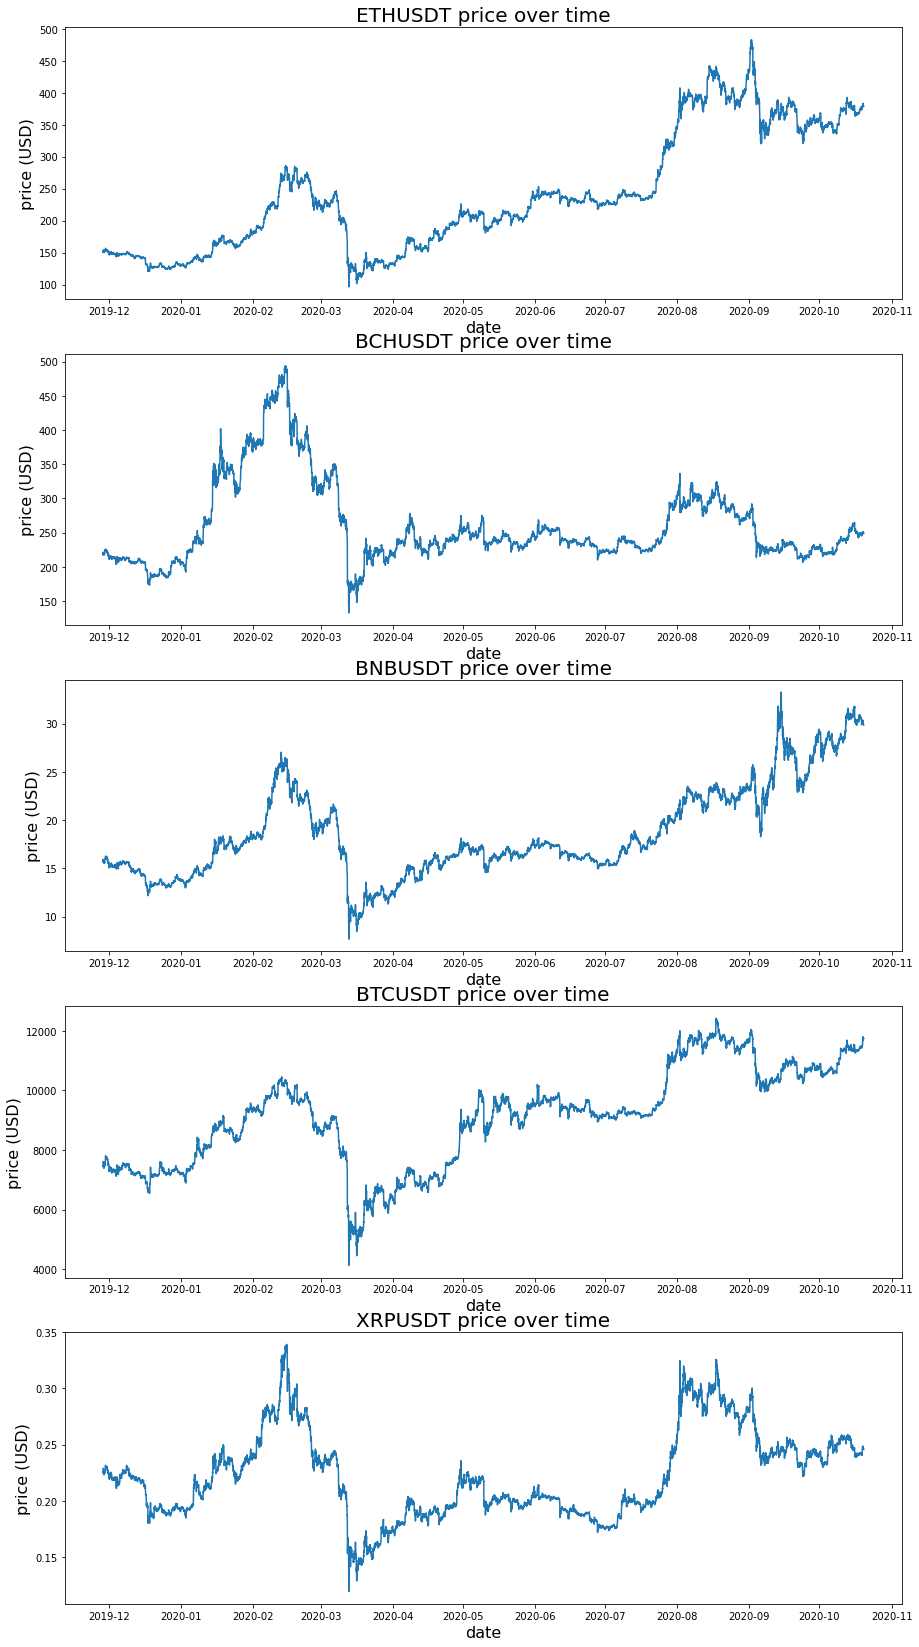

In [6]:
fig, ax = plt.subplots(len(df),figsize=(15, 29))

for i in range(len(df)):
    ax[i].plot(df[list(df.keys())[i]]['close']) # stacked plot of each of the currencies
    ax[i].set_title(list(df.keys())[i] + ' price over time',fontsize = 20) # set plot titles
    

# set axes lab%matplotlib inlineels
for i in range(len(df)):
    ax[i].set_xlabel('date',fontsize=16)
    ax[i].set_ylabel('price (USD)', fontsize=16)

In [7]:
# calculate correlations for closing prices of cryptocurrencies
df_cor = pd.DataFrame()
for key in df:
    #print(key)
    df_cor[key] = df[key]['close']

In [8]:
df_cor.corr()

,ETHUSDT,BCHUSDT,BNBUSDT,BTCUSDT,XRPUSDT
ETHUSDT,1.000000,0.184688,0.853670,0.919466,0.714901
BCHUSDT,0.184688,1.000000,0.355955,0.373509,0.672619
BNBUSDT,0.853670,0.355955,1.000000,0.836482,0.755844
BTCUSDT,0.919466,0.373509,0.836482,1.000000,0.763675
XRPUSDT,0.714901,0.672619,0.755844,0.763675,1.000000


highest correlation exists between BTC/ETH > BTC/BNB > XRP/ETH then BTC>XRP etc. Let's do pairs trading on BTC/ETH.

perform feature scaling (wasn't used in the end)

In [9]:
df_scaled=pd.DataFrame()
for key in df:
    df_scaled[key] = (df[key]['close'] - df[key]['close'].mean()) / df[key]['close'].std()

## Pairs trading with a rolling window

Define a moving window and move it over our time series

In [10]:
windowLength = 1000

In [11]:
forecastLength = len(df_hourly['BTCUSDT']) - windowLength

In [12]:
forecastLength

6827

In [15]:
df_hourly['BTCUSDT'].index[0]

Timestamp('2019-11-28 10:00:00')

In [16]:
# implement pairs trading by getting z-scores over a windowlength = 1000 hour rolling window.
# store these z-scores in a list

offset_BTC = pd.DataFrame() # offset refers to time series within a windowlength
offset_ETH = pd.DataFrame()
df_trade = pd.DataFrame()
trade_dates=[]
z_scores=[]

for i in range(0,forecastLength):
    offset_BTC = df_hourly['BTCUSDT']['close'][i:(windowLength+i)]
    offset_ETH = df_hourly['ETHUSDT']['close'][i:(windowLength+i)]
    
    # perform OLS to obtain parameters for spread prediction
    Y = offset_BTC
    X = offset_ETH
    X = sm.add_constant(X)
    model = sm.OLS(Y,X)
    results = model.fit()
    const, beta = results.params
    
    #spread over the given window are the residuals from the OLS regression
    rolling_spread = results.resid
    instantaneous_spread = df_hourly['BTCUSDT']['close'][(windowLength+i)] - beta * \
    df_hourly['ETHUSDT']['close'][(windowLength+i)] - const
    
    z_scores.append((instantaneous_spread - rolling_spread.mean())/rolling_spread.std())
    trade_dates.append(df_hourly['BTCUSDT'].index[(windowLength+i)])
    

Spread was modelled using linear regression: $\mathrm{ETHUSDT} = \beta \times \mathrm{BTCUSDT} + \mathrm{const.} $
then $\mathrm{spread} = \mathrm{ETHUSDT} - \beta \times \mathrm{BTCUSDT} - \mathrm{const.}$ (from the course notes)

In [17]:
# combine useful results from the previous cell into a separate df
df_trade['date'] = trade_dates
df_trade['z-score'] = z_scores
df_trade.set_index('date', inplace=True)
df_trade = df_trade.shift(1) # shift forward by one time period to avoid look ahead bias
df_trade = df_trade.dropna()
df_trade

,z-score
date,
2020-01-09 03:00:00,2.763777
2020-01-09 04:00:00,2.655590
2020-01-09 05:00:00,2.693555
2020-01-09 06:00:00,2.620947
2020-01-09 07:00:00,2.451271
2020-01-09 08:00:00,2.588180
2020-01-09 09:00:00,2.539614
2020-01-09 10:00:00,2.332667
2020-01-09 11:00:00,2.391065


## Implement trading logic

In [18]:
def get_portfolio_value(date0,cash0,nBTC0=0,nETH0=0):
    """
    returns the value of a portfolio in USD on a given date given cash, number of bitcoin and number of ethereum
    date - str
    everything else - floats
    """
    return cash0 + nBTC0*df_hourly['BTCUSDT']['close'].loc[date0] + nETH0*df_hourly['ETHUSDT']['close'].loc[date0]

In [19]:
# buy and hodl strategy
df_hodl = pd.DataFrame()
starting_capital = 100000. # start out with $100000USDT
cash = []
cash.append(starting_capital)
nBTC = []
nBTC.append(0.)
buy_amount = 10. # when purchasing BTC, how much USD should be used per transaction

total_value = []
total_value.append(get_portfolio_value(df_trade.index[0], starting_capital))

for date in df_trade.index:
    # print(df_trade['z-score'].loc[date])
    nBTC.append(nBTC[-1]+buy_amount/df_hourly['BTCUSDT']['close'].loc[date])
    cash.append(cash[-1]-buy_amount)
    total_value.append(get_portfolio_value(date, cash[-1], nBTC[-1]))
    
df_hodl['date'] = trade_dates
df_hodl['cash'] = cash
df_hodl['nBTC'] = nBTC
df_hodl['portfolio value'] = total_value
df_hodl.set_index('date', inplace=True)

if z score > 2, buy \\$10 ETH, sell \\$10 BTC
if z score < -2, buy \\$10 BTC, sell $10 ETH
(ignored for now, causes excessive drawdowns) if |z score| < 0.5, sell \\$10 each of BTC and ETH

portfolio starting capital \\$100 000 split $20 000 in cash and \\$80 000 1:1 in ETH, BTC.



In [20]:
# BTC/ETH pairs trading 
# 
# start with 60 000 cash, 20 000 BTC, 20 000 ETH
df_pairs = pd.DataFrame()
starting_capital = 20000. # start out with $100000USDT

cash = []
cash.append(starting_capital)

nBTC = []
nBTC.append(40000./df_hourly['BTCUSDT']['close'].loc[df_trade.index[0]])

nETH = []
nETH.append(40000./df_hourly['ETHUSDT']['close'].loc[df_trade.index[0]])

total_value = []
total_value.append(get_portfolio_value(df_trade.index[0], starting_capital, nBTC[0], nETH[0]))

# different types of trade signals, will be used for plotting step (next cell)
# 3 - buy ETH
# 2 - buy BTC
# 1 - liquidate half # not relevant for our submission

trade_signal = []
trade_signal.append(0)

buy_amount = 100. # buy and sell amount in usd per transaction

for date in df_trade.index[1:]: 
    # we start at 1: because we need to compare z-score from two time periods ago 
    # so we don't generate too many trading signals
    
    # get integer location of date in df_trade.index
    date_loc = df_trade.index.get_loc(date) 
    
    # if z-score is greater than 2 and the previous z-score was less than 2, buy ETH, sell BTC 
    if df_trade['z-score'].loc[date] > 2 and df_trade['z-score'].iloc[date_loc-1] < 2: 
        nBTC.append(nBTC[-1]-buy_amount/df_hourly['BTCUSDT']['close'].loc[date])
        nETH.append(nETH[-1]+buy_amount/df_hourly['ETHUSDT']['close'].loc[date])
        cash.append(cash[-1])
        total_value.append(get_portfolio_value(date, cash[-1],nBTC[-1],nETH[-1]))
        trade_signal.append(3)
        
    # if z-score is less than -2 and the previous z-score was greater than -2, buy BTC, sell ETH 
    elif df_trade['z-score'].loc[date] < -2 and df_trade['z-score'].iloc[date_loc-1] > -2:
        nBTC.append(nBTC[-1]+buy_amount/df_hourly['BTCUSDT']['close'].loc[date])
        nETH.append(nETH[-1]-buy_amount/df_hourly['ETHUSDT']['close'].loc[date])
        cash.append(cash[-1])
        total_value.append(get_portfolio_value(date, cash[-1],nBTC[-1],nETH[-1]))
        trade_signal.append(2)
        
        # obsolete code, used for liquidating holdings
    # liquidate half your holdings if z-score is between plus/minus 0.5 to avoid overexposure
    # elif abs(df_trade['z-score'].loc[date]) < 0.5 and abs(df_trade['z-score'].iloc[date_loc-1]) > 0.5:
    
    #elif abs(df_trade['z-score'].loc[date]) < 0.5 and abs(df_trade['z-score'].iloc[date_loc-1]) > 0.5:
    #    cash.append(cash[-1]+nBTC[-1]/2.*df_hourly['BTCUSDT']['close'].loc[date] + nETH[-1]/2.\
     #               *df_hourly['ETHUSDT']['close'].loc[date])
      #  nBTC.append(nBTC[-1]/2.)
       # nETH.append(nETH[-1]/2.)
        #nBTC.append(nBTC[-1]-buy_amount/df_hourly['BTCUSDT']['close'].loc[date])
        #nETH.append(nETH[-1]-buy_amount/df_hourly['ETHUSDT']['close'].loc[date])
        #cash.append(cash[-1]+2*buy_amount)
        #total_value.append(get_portfolio_value(date, cash[-1],nBTC[-1],nETH[-1]))
        #trade_signal.append(1)
    # otherwise nothing changes
    
    # if no z-score criterion are met, the portfolio's value doesn't change
    # take the previous entries values
    else:
        nBTC.append(nBTC[-1])
        nETH.append(nETH[-1])
        cash.append(cash[-1])
        total_value.append(get_portfolio_value(date, cash[-1],nBTC[-1],nETH[-1]))
        trade_signal.append(0)
        
        
# combine useful results from the previous cell into a separate df
df_pairs['date'] = trade_dates[1:]
df_pairs['cash'] = cash
df_pairs['nBTC'] = nBTC
df_pairs['nETH'] = nETH
df_pairs['portfolio value'] = total_value
df_pairs['signal'] = trade_signal
df_pairs.set_index('date', inplace=True)

In [21]:
df_pairs

,cash,nBTC,nETH,portfolio value,signal
date,,,,,
2020-01-09 03:00:00,20000.0,5.028461,285.836787,100000.000000,0
2020-01-09 04:00:00,20000.0,5.028461,285.836787,100072.428705,0
2020-01-09 05:00:00,20000.0,5.028461,285.836787,99712.230443,0
2020-01-09 06:00:00,20000.0,5.028461,285.836787,99615.990462,0
2020-01-09 07:00:00,20000.0,5.028461,285.836787,99972.602742,0
2020-01-09 08:00:00,20000.0,5.028461,285.836787,99722.640967,0
2020-01-09 09:00:00,20000.0,5.028461,285.836787,99111.316593,0
2020-01-09 10:00:00,20000.0,5.028461,285.836787,99406.510953,0
2020-01-09 11:00:00,20000.0,5.028461,285.836787,99131.109865,0


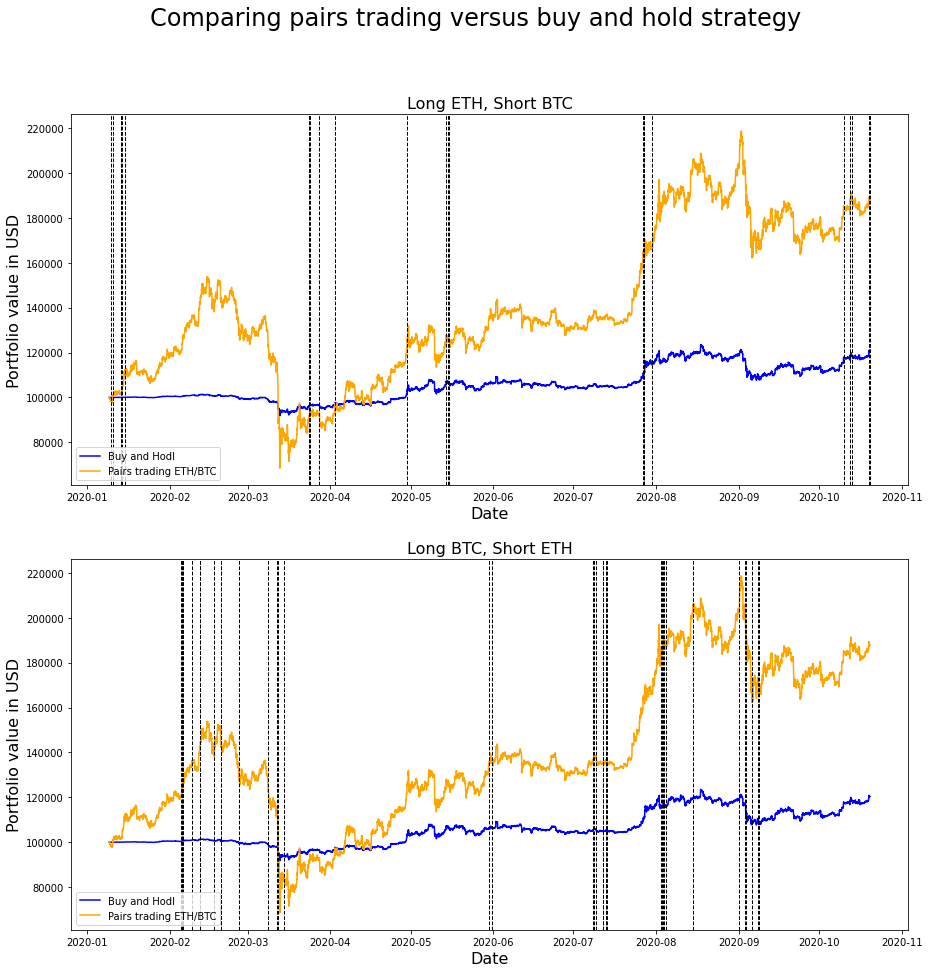

In [22]:
# generate plots: 1st plot shows trading signals (dotted vertical lines) where ETH is bought and BTC is sold
# 2nd plot shows trading signals (dotted vertical lines) where BTC is bought and ETH is sold
# pairs trading gives much better returns but worse drawdowns and more volatility
# buy and hold gives consistent returns

fig, ax = plt.subplots(2,figsize=(15,15))
for i in range(2):
    ax[i].plot(df_hodl['portfolio value'], color='blue', label='Buy and Hodl')
    ax[i].plot(df_pairs['portfolio value'], color='orange', label='Pairs trading ETH/BTC')
    ax[i].set_xlabel('Date',fontsize=16)
    ax[i].set_ylabel('Portfolio value in USD',fontsize=16)
    ax[i].legend(loc='lower left')

    fig.suptitle('Comparing pairs trading versus buy and hold strategy', fontsize=24)

ax[0].set_title('Long ETH, Short BTC', fontsize=16)
ax[1].set_title('Long BTC, Short ETH', fontsize=16)
    
for d in df_pairs.index[df_pairs.signal==3]:
    ax[0].axvline(d,color='black',linestyle='--',linewidth='1')

for d in df_pairs.index[df_pairs.signal==2]:
    ax[1].axvline(d,color='black',linestyle='--',linewidth='1')


## Code for testing (old obsolete)

pairs trading on XRP/BTC pair

In [16]:
# calculate spread on mBTC/XRP pair on adjusted close
# should do regression and correlation analysis first
df_spread = df['BTCUSDT']['close']/10000. - df['XRPUSDT']['close']

/home/joseph/miniconda3/envs/mscfe3/lib/python3.6/site-packages/pandas/plotting/_compat.py:57: MatplotlibDeprecationWarning: 
The compare_versions function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  return matplotlib.compare_versions('2.0.0', matplotlib.__version__)


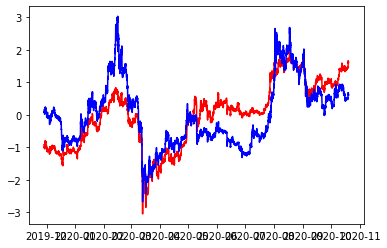

In [60]:
# plot price of symbols to get an idea of scaling
plt.plot(df_scaled['BTCUSDT'], color = 'red')
plt.plot(df_scaled['XRPUSDT'], color = 'blue')

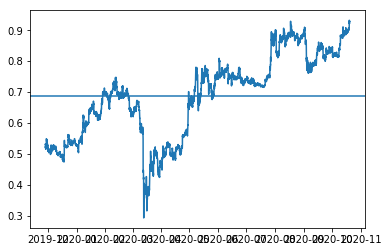

In [17]:
# plot spread
plt.plot(df_spread)
plt.axhline(df_spread.mean());

## Cointegration tests (incomplete but optional)

In [ ]:
df_johansen = pd.DataFrame()
for key in df:
    df_johansen[key] = df[key]['close']

In [ ]:
# we could screen through parameters det_order=[-1,0,1] and k_ar_diff=[0,1] using grid search when there's time
result = sm.tsa.var.vecm.coint_johansen(df_johansen,0,1)

model spread using linear regression: $\mathrm{ETHUSDT} = \beta \times \mathrm{BTCUSDT} + \mathrm{const.} $

In [ ]:
Y = df_scaled['ETHUSDT']
X = df_scaled['BTCUSDT']
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()
results.summary()

In [ ]:
# BTC/ETH pairs trading
# get_portfolio_value(df_trade.index[0], starting_capital)
df_pairs = pd.DataFrame()
starting_capital = 0. # start out with $100000USDT
cash = []
cash.append(starting_capital)
nBTC = []
nBTC.append(50000./df_hourly['BTCUSDT']['close'].loc[df_trade.index[0]])

nETH = []
nETH.append(50000./df_hourly['ETHUSDT']['close'].loc[df_trade.index[0]])

total_value = []
total_value.append(get_portfolio_value(df_trade.index[0], starting_capital, nBTC[0], nETH[0]))

buy_amount = 50. # buy and sell amount in usd per transaction

# buy $10 BTC every hour

for date in df_trade.index:
    if df_trade['z-score'].loc[date] > 2:
        nBTC.append(nBTC[-1]-buy_amount/df_hourly['BTCUSDT']['close'].loc[date])
        nETH.append(nETH[-1]+buy_amount/df_hourly['ETHUSDT']['close'].loc[date])
        cash.append(cash[-1])
        total_value.append(get_portfolio_value(date, cash[-1],nBTC[-1],nETH[-1]))
    elif df_trade['z-score'].loc[date] < -2:
        nBTC.append(nBTC[-1]+buy_amount/df_hourly['BTCUSDT']['close'].loc[date])
        nETH.append(nETH[-1]-buy_amount/df_hourly['ETHUSDT']['close'].loc[date])
        cash.append(cash[-1])
        total_value.append(get_portfolio_value(date, cash[-1],nBTC[-1],nETH[-1]))
    elif abs(df_trade['z-score'].loc[date]) < 0.5:
        nBTC.append(nBTC[-1]-buy_amount/df_hourly['BTCUSDT']['close'].loc[date])
        nETH.append(nETH[-1]-buy_amount/df_hourly['ETHUSDT']['close'].loc[date])
        cash.append(cash[-1]+2*buy_amount)
        total_value.append(get_portfolio_value(date, cash[-1],nBTC[-1],nETH[-1]))
    else:
        nBTC.append(nBTC[-1])
        nETH.append(nETH[-1])
        cash.append(cash[-1])
        total_value.append(get_portfolio_value(date, cash[-1],nBTC[-1],nETH[-1]))
        # do nothing, take the previous array's value
        

df_pairs['date'] = trade_dates
df_pairs['cash'] = cash
df_pairs['nBTC'] = nBTC
df_pairs['portfolio value'] = total_value
df_pairs.set_index('date', inplace=True)